In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from build_vocab import Vocabulary
from model import EncoderCNN, EncoderRNN, Model
from PIL import Image
import ipdb


# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
torch.cuda.manual_seed_all(100)

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary wrapper
    with open(args.inverse_object_id_mapping, 'rb') as f:
        inverse_object_id_mapping = pickle.load(f)
    num_objects = len(inverse_object_id_mapping.keys())

    # Build models
    encoderCNN = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    encoderRNN = EncoderRNN(num_objects, args.embed_size, args.hidden_size)
    model = Model(num_objects, args.embed_size)
    encoderCNN = encoderCNN.to(device)
    encoderRNN = encoderRNN.to(device)
    model = model.to(device)
    encoderCNN.eval()
    encoderRNN.eval()
    model.eval()

    # Load the trained model parameters
    encoderCNN.load_state_dict(torch.load(args.encoderCNN_path))
    encoderRNN.load_state_dict(torch.load(args.encoderRNN_path))
    model.load_state_dict(torch.load(args.model_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    image_features = encoderCNN(image_tensor)
    input = torch.LongTensor([[[1]]]).to(device)
    h0 = torch.zeros((1, 1, args.hidden_size)).to(device)
    c0 = torch.zeros((1, 1, args.hidden_size)).to(device)
    max_seqlen = 10
    result = []
    K = 3
    all_candidates = [([1], 1.0, h0, c0) for i in range(K)]
    for i in range(max_seqlen):
        Q = []
        for _k in range(K):
            if i == 0 and _k == 1: # first word
                break

            hashtag_features, (h0, c0), Ul = encoderRNN(input[_k], all_candidates[_k][2], all_candidates[_k][3])
            outputs = model(image_features, hashtag_features, Ul)
            prob, topk = torch.topk(outputs, 20, dim=1)
            tup = list(zip(topk[0].cpu().tolist(), prob[0].cpu().tolist()))
            topk = [a for a in tup if a[0] not in all_candidates[_k][0]]
            try:
                topk.remove(1)
                topk.remove(0)
            except:
                pass

            for _k_ in range(K):
                Q.append((all_candidates[_k][0]+[topk[_k_][0]], abs(all_candidates[_k][1]*topk[_k_][1]), h0, c0))

        all_candidates = sorted(Q, key=lambda x: x[1], reverse=True)[:K]
        input = []
        for _k in range(K):
            input.append([[all_candidates[_k][0][-1]]])
        input = torch.LongTensor(input).to(device)
        #result.append(top1.cpu().numpy()[0][0])
    result = sorted(all_candidates, key=lambda x: x[1], reverse=True)
    result = [i[0] for i in result]
    print(result)
    for i in range(1):
        tmp = [inverse_object_id_mapping[j] for j in result[i]]
        #final = zip([j['name'] for j in tmp], [j['supercategory'] for j in tmp])
        for j in tmp:
            print(j)
        print("-"*50)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))

In [84]:
#img_files = [os.path.join('../data/train2014/', i) for i in os.listdir('../data/train2014/')]
img_files = [os.path.join('./data/dataset/', i) for i in os.listdir('./data/dataset/')]

[[1, 3, 18, 20, 62, 29, 15, 60, 8, 21, 47], [1, 3, 18, 20, 62, 29, 15, 60, 8, 21, 53], [1, 3, 18, 20, 62, 29, 15, 22, 8, 72, 4]]
<START>
love
sun
instagood
instagram
cute
beautiful
life
girl
nature
white
--------------------------------------------------


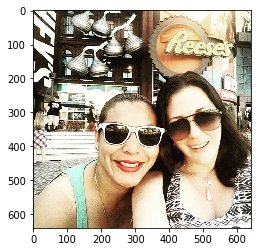

In [102]:
torch.cuda.manual_seed_all(1124)
class ARGS:
    def __init__(self, img_id, epoch, step):
        self.image = img_files[img_id]
        self.encoderCNN_path = 'hashtag_models/encoderCNN-'+str(epoch)+'-'+str(step)+'.ckpt'
        self.encoderRNN_path = 'hashtag_models/encoderRNN-'+str(epoch)+'-'+str(step)+'.ckpt'
        self.model_path = 'hashtag_models/model-'+str(epoch)+'-'+str(step)+'.ckpt'
        #self.inverse_object_id_mapping = './inverse_object_id_mapping.pkl'
        self.inverse_object_id_mapping = './data/inverse_mapping.pkl'

        # Model parameters (should be same as paramters in train.py)
        self.embed_size = 64
        self.hidden_size = 512
        self.num_layers = 1

args = ARGS(img_id=40, epoch=30, step=2800)  # epoch是3的倍數，目前最多30；step=1400 or 2800
main(args)